In [1]:
%load_ext autoreload 
%autoreload 2

import sys
import json
import re
import pandas as pd
import pickle
from numpy.testing import assert_allclose
from pathlib import Path

from dask.distributed import Client
from sklearn import set_config
from macro_utils import load_datastore

# internal
sys.path.append(r"C:/ami")
sys.path.append(r"C:/SyMAWoFlo/Symawofo")

In [ ]:
df_master, meta, var_group = load_datastore()

In [2]:
from symawofo import FeatureFrame, DataSplitter, WindowFrame, get_client
# client = get_client()


## getting the data and running the model

In [3]:
from ami.run.macrobot import MacrobotRunner

asset = 'FX_MXN_TR'
runner = MacrobotRunner(asset)


In [4]:
spec = runner.jobspec

In [5]:
spec.ensemble.n_estimators = 2
spec.ensemble.agg_fn = None

## now you can check the source code used to generate the model (will be inseart into next cell)

In [6]:
runner.get_source_into_next_cell()

In [10]:
import numpy as np
from ami.build.loss import get_loss_fn
from ami.macrobot.jobspec import Jobspec
from ami.macrobot.models import GRURegressor, CNNRegressor
from symawofo.ensemble import BaggingRegressor

from symawofo.transformers import (Clipper, Difference, Lag, make_column_transformer,
                                   make_pipeline,
                                   StandardScaler, TransformedTargetRegressor)
from symawofo import FeatureFrame, DataSplitter, WindowFrame
from symawofo.signals import ThresholdSingSignal
from macro_utils import DotDict
from ami.build.common import make_pca_column_transformer, make_pca_diff_column_transformer
from ami.macrobot.models import GRURegressor, CNNRegressor

#%%

def decay_weights(decay):
    if decay:
        def weight_fn(X):
            return decay**np.arange(len(X))[::-1]
        return weight_fn

def make_preprocessing(target, prediction_lag):
    target_prepipeline = make_pipeline(
            Difference(),
            Lag(-prediction_lag)
    )
    return target_prepipeline.fit_transform(target)


def make_feature_transform(config: DotDict):
    tr_pca_levels = make_pca_column_transformer(config.PCA)
    tr_pca_diffs = make_pca_diff_column_transformer(config.PCA_diff)
    tr_level_features = [('passthrough', config.pass_through)]
    tr_diffs = [(Difference(1), config.diff)]

    ct = tr_pca_levels + tr_pca_diffs + tr_level_features + tr_diffs

    return make_pipeline(
            make_column_transformer(*ct, remainder='drop'),
            StandardScaler(),
            Clipper(-config.clip_level, config.clip_level)
    )


def make_model(**kwargs):
    kwargs = dict(kwargs)
    kwargs['loss'] = get_loss_fn(kwargs['loss'])
    sample_weights_fn = decay_weights(kwargs.get('decay'))
    if kwargs.pop('type') == 'GruModel':
        return GRURegressor(_sample_weight_fn=sample_weights_fn, **kwargs)
    else:
        return CNNRegressor(_sample_weight_fn=sample_weights_fn, **kwargs)


def make_ensemble_model(jobspec: DotDict):
    model = make_model(**jobspec.model)
    feature_transform = make_feature_transform(jobspec.features_transform)

    if jobspec.ensemble and jobspec.ensemble.pop('type') == 'bagging':
        model = BaggingRegressor(model, **jobspec.ensemble)

    estimator = make_pipeline(
            feature_transform,
            model
    )
    target_postpipline = make_pipeline(
            StandardScaler(with_mean=jobspec.target_transform.with_mean),
            Clipper(-jobspec.target.clip_level, jobspec.target.clip_level))

    return TransformedTargetRegressor(estimator, target_postpipline)


def make_data_splitter(jobspec: DotDict):
    return  DataSplitter(
            test_size=jobspec.data_splitter.test_size,
            initial_training_size=jobspec.data_splitter.initial_training_size,
            expanding=jobspec.data_splitter.expanding,
            drop_remaining=True,
            last_training_window=True
    )


def make_window_frame(jobspec: DotDict, data):
    target = data[jobspec.target.name]
    modeling_features = FeatureFrame(data=data)
    modeling_target = make_preprocessing(target, jobspec.target.prediction_lag)

    splitter = make_data_splitter(jobspec)
    targetRegressor = make_ensemble_model(jobspec)

    wf = WindowFrame(
            features=modeling_features,
            target=modeling_target,
            splitter=splitter
    ).build(
            estimator=targetRegressor
    )

    return wf

#%%

def main():
    from ami.run.macrobot import MacrobotRunner

    spec = Jobspec({
    "data_splitter": {
        "expanding": 1,
        "initial_training_size": 375,
        "test_size": 13
    },
    "ensemble": {
        "agg_fn": None,
        "max_samples": 0.9,
        "n_estimators": 2,
        "type": "bagging"
    },
    "features_transform": {
        "PCA": [
            "US_ConsConf"
        ],
        "PCA_diff": [
            "US_Growth",
            "US_ConsConf",
            "US_Inflation",
            "US_Credit_Growth",
            "US_Inflexp",
            "US_FCI",
            "US_Risk",
            "US_WageExp"
        ],
        "clip_level": 8,
        "diff": [
            "GLOB_Equity",
            "US_Breakeven55",
            "US_Bond_10y",
            "US_erp_est",
            "US_AAII_Net",
            "US_CECI",
            "US_eps_upgrade_ratio"
        ],
        "pass_through": [
            "eq_per_flows_USA",
            "eq_ctry2_UnitedStates50_20",
            "US_AAII_Net",
            "US_CFTC_SPX",
            "US_erp_est",
            "US_GSInn",
            "US_Fiscal_Bal",
            "GLOB_CB_Bal",
            "US_CB_Bal",
            "US_2y_v_OIS",
            "US_ForYieldSp",
            "GLOB_EM_HCSp",
            "US_Buybacks_SPX_BBG",
            "US_MA_BBG",
            "GLOB_Equity_Skew",
            "US_Equity_Fut_Chg13",
            "US_Equity_Fut_Chg4",
            "US_CECI",
            "US_eps_upgrade_ratio",
            "ES_Volume_MA",
            "US_Equity_Fut_MASignal",
            "US_Equity_Fut_RSI"
        ]
    },
    "model": {
        "activation": "selu",
        "batch_norm": True,
        "batch_size": 1000,
        "decay": 0.3,
        "dropout": 0.05,
        "epochs": 100,
        "lookback_periods": 13,
        "loss": "mse",
        "nodes": 15,
        "optimizer": "adam",
        "regularizer_l1": 0.003,
        "regularizer_l2": 0.0,
        "type": "GruModel",
        "use_bias": False
    },
    "target": {
        "clip_level": 3,
        "name": "US_Equity_Fut",
        "prediction_lag": 1
    },
    "target_transform": {
        "type": "StandardScaler",
        "with_mean": False
    },
    "signal": {
        "threshold": 0.000001
    }
})
    runner = globals().get('runner', MacrobotRunner(spec.target.name))
    data = runner.get_data()
    wf = make_window_frame(spec, data)
    tradeSignal = ThresholdSingSignal(wf, **spec.signal)
    return tradeSignal


In [11]:
signal = main()

In [12]:
signal.signals

Window(start=2005-06-17 00:00:00, end=2013-02-15 00:00:00, model=BaggingRegressor)


c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1274
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1226
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1174
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1125
Epoch 5/100
1/1 [==============================] - 0s 997us/step - loss: 0.1079
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1031
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0986
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0941
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0898
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0856
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0815
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0775
Epoch 13/100
1/1 [==============================] - 0s 10ms

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1675
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1611
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1534
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1466
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1392
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1343
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1287
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1213
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1163
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1108
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1065
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1020
Epoch 13/100
1/1 [==============================] - 0s 2ms/st

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1294
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1243
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1194
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1146
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1098
Epoch 6/100
1/1 [==============================] - 0s 998us/step - loss: 0.1053
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1008
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0964
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0921
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0879
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0839
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0800
Epoch 13/100
1/1 [==============================] - 0s 3ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1274
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1223
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1174
Epoch 4/100
1/1 [==============================] - 0s 996us/step - loss: 0.1126
Epoch 5/100
1/1 [==============================] - 0s 999us/step - loss: 0.1079
Epoch 6/100
1/1 [==============================] - 0s 999us/step - loss: 0.1034
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0990
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0946
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0904
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0863
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0822
Epoch 12/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0783
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1265
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1216
Epoch 3/100
1/1 [==============================] - 0s 997us/step - loss: 0.1164
Epoch 4/100
1/1 [==============================] - 0s 999us/step - loss: 0.1114
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1066
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1020
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0976
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0934
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0890
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0849
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0808
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0770
Epoch 13/100
1/1 [==============================] - 0s 2m

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 996us/step - loss: 0.1297
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1247
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1195
Epoch 4/100
1/1 [==============================] - 0s 997us/step - loss: 0.1145
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1098
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1049
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1006
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0963
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0918
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0876
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0838
Epoch 12/100
1/1 [==============================] - 0s 999us/step - loss: 0.0797
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1301
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1251
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1202
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1155
Epoch 5/100
1/1 [==============================] - 0s 997us/step - loss: 0.1108
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1062
Epoch 7/100
1/1 [==============================] - 0s 996us/step - loss: 0.1017
Epoch 8/100
1/1 [==============================] - 0s 998us/step - loss: 0.0973
Epoch 9/100
1/1 [==============================] - 0s 998us/step - loss: 0.0931
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0888
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0848
Epoch 12/100
1/1 [==============================] - 0s 999us/step - loss: 0.0808
Epoch 13/100
1/1 [==============================] -

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1279
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1230
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1173
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1125
Epoch 5/100
1/1 [==============================] - 0s 999us/step - loss: 0.1078
Epoch 6/100
1/1 [==============================] - 0s 999us/step - loss: 0.1031
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0986
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0943
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0901
Epoch 10/100
1/1 [==============================] - 0s 985us/step - loss: 0.0861
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0821
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0783
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1315
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1262
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1211
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1163
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1118
Epoch 6/100
1/1 [==============================] - 0s 1000us/step - loss: 0.1072
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1027
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0982
Epoch 9/100
1/1 [==============================] - 0s 998us/step - loss: 0.0939
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0898
Epoch 11/100
1/1 [==============================] - 0s 996us/step - loss: 0.0858
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0817
Epoch 13/100
1/1 [==============================] - 0s

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1317
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1255
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1207
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1156
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1108
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1063
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1021
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0982
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0941
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0900
Epoch 11/100
1/1 [==============================] - 0s 1000us/step - loss: 0.0862
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0828
Epoch 13/100
1/1 [==============================] - 0s 3ms

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1299
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.1247
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1197
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1147
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1100
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1054
Epoch 7/100
1/1 [==============================] - 0s 999us/step - loss: 0.1011
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0967
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0923
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0881
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0841
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0800
Epoch 13/100
1/1 [==============================] - 0s 3ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1294
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1243
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1191
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1145
Epoch 5/100
1/1 [==============================] - 0s 10ms/step - loss: 0.1096
Epoch 6/100
1/1 [==============================] - 0s 998us/step - loss: 0.1049
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1005
Epoch 8/100
1/1 [==============================] - 0s 999us/step - loss: 0.0961
Epoch 9/100
1/1 [==============================] - 0s 999us/step - loss: 0.0918
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0877
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0838
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0799
Epoch 13/100
1/1 [==============================] - 0s

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1283
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1233
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1185
Epoch 4/100
1/1 [==============================] - 0s 998us/step - loss: 0.1137
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1091
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1045
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1001
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0957
Epoch 9/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0914
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0873
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0833
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0794
Epoch 13/100
1/1 [==============================] - 0s 2ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1303
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1252
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1199
Epoch 4/100
1/1 [==============================] - 0s 1000us/step - loss: 0.1148
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1099
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1052
Epoch 7/100
1/1 [==============================] - 0s 9ms/step - loss: 0.1005
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0963
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0918
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0879
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0836
Epoch 12/100
1/1 [==============================] - 0s 1000us/step - loss: 0.0798
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1391
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1343
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1277
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1222
Epoch 5/100
1/1 [==============================] - 0s 998us/step - loss: 0.1171
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1117
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1081
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1023
Epoch 9/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0978
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0930
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0890
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0852
Epoch 13/100
1/1 [==============================] - 0s 2ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1287
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1237
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1187
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1138
Epoch 5/100
1/1 [==============================] - 0s 1000us/step - loss: 0.1091
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1046
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1001
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0957
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0913
Epoch 10/100
1/1 [==============================] - 0s 999us/step - loss: 0.0872
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0834
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0794
Epoch 13/100
1/1 [==============================] - 0s 3

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1332
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1264
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1212
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1163
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1110
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1063
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1023
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0978
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0939
Epoch 10/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0900
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0863
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0825
Epoch 13/100
1/1 [==============================] - 0s 997us/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1316
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1265
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1214
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1163
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1116
Epoch 6/100
1/1 [==============================] - 0s 995us/step - loss: 0.1071
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1025
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0979
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0939
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0894
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0852
Epoch 12/100
1/1 [==============================] - 0s 998us/step - loss: 0.0812
Epoch 13/100
1/1 [==============================] - 0s 4m

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1382
Epoch 2/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1325
Epoch 3/100
1/1 [==============================] - 0s 997us/step - loss: 0.1263
Epoch 4/100
1/1 [==============================] - 0s 998us/step - loss: 0.1210
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1163
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1117
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1078
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1030
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0989
Epoch 10/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0953
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0906
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0863
Epoch 13/100
1/1 [==============================] - 0s 1

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1290
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1237
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1188
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1140
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1090
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1045
Epoch 7/100
1/1 [==============================] - 0s 999us/step - loss: 0.1000
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0957
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0916
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0875
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0835
Epoch 12/100
1/1 [==============================] - 0s 986us/step - loss: 0.0795
Epoch 13/100
1/1 [==============================] - 0s 2m

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1270
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1220
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1170
Epoch 4/100
1/1 [==============================] - 0s 993us/step - loss: 0.1121
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1074
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1028
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0983
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0939
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0897
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0856
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0815
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0776
Epoch 13/100
1/1 [==============================] - 0s 2ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 997us/step - loss: 0.1301
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1256
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1205
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1155
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1106
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1062
Epoch 7/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1013
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0970
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0927
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0885
Epoch 11/100
1/1 [==============================] - 0s 998us/step - loss: 0.0845
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0806
Epoch 13/100
1/1 [==============================] - 0s 99

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1718
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1638
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1571
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1480
Epoch 5/100
1/1 [==============================] - 0s 1000us/step - loss: 0.1422
Epoch 6/100
1/1 [==============================] - 0s 997us/step - loss: 0.1369
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1298
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1242
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1161
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1098
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1051
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0996
Epoch 13/100
1/1 [==============================] - 0s 2

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 998us/step - loss: 0.2735
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.2560
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2399
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2287
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2151
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2036
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1927
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1840
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1721
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1643
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1522
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1449
Epoch 13/100
1/1 [==============================] - 0s 3ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1801
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1719
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1637
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1598
Epoch 5/100
1/1 [==============================] - 0s 29ms/step - loss: 0.1523
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1462
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1404
Epoch 8/100
1/1 [==============================] - 0s 997us/step - loss: 0.1328
Epoch 9/100
1/1 [==============================] - 0s 999us/step - loss: 0.1273
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1221
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1147
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1099
Epoch 13/100
1/1 [==============================] - 0s 2

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 985us/step - loss: 0.1902
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1840
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1763
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1693
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1638
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1584
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1530
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1461
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1429
Epoch 10/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1372
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1323
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1266
Epoch 13/100
1/1 [==============================] - 0s 2ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 995us/step - loss: 0.1475
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1409
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1354
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1280
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1221
Epoch 6/100
1/1 [==============================] - 0s 999us/step - loss: 0.1166
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1125
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1095
Epoch 9/100
1/1 [==============================] - 0s 997us/step - loss: 0.1048
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0982
Epoch 11/100
1/1 [==============================] - 0s 997us/step - loss: 0.0941
Epoch 12/100
1/1 [==============================] - 0s 988us/step - loss: 0.0905
Epoch 13/100
1/1 [==============================] -

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1408
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1349
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1293
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1228
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1179
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1130
Epoch 7/100
1/1 [==============================] - 0s 998us/step - loss: 0.1083
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1042
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0990
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0950
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0909
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0865
Epoch 13/100
1/1 [==============================] - 0s 2ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 986us/step - loss: 0.1305
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1254
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1204
Epoch 4/100
1/1 [==============================] - 0s 994us/step - loss: 0.1156
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1109
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1063
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1019
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0976
Epoch 9/100
1/1 [==============================] - 0s 998us/step - loss: 0.0933
Epoch 10/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0892
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0851
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0813
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1300
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1249
Epoch 3/100
1/1 [==============================] - 0s 996us/step - loss: 0.1200
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1152
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1106
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1059
Epoch 7/100
1/1 [==============================] - 0s 997us/step - loss: 0.1015
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0970
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0929
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0885
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0844
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0806
Epoch 13/100
1/1 [==============================] - 0s 2m

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1292
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1242
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1193
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1145
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1098
Epoch 6/100
1/1 [==============================] - 0s 995us/step - loss: 0.1052
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1007
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0963
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0920
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0879
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0838
Epoch 12/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0798
Epoch 13/100
1/1 [==============================] - 0s 998

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 998us/step - loss: 0.1285
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1235
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1186
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1137
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1090
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1044
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0999
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0955
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0913
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0871
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0830
Epoch 12/100
1/1 [==============================] - 0s 998us/step - loss: 0.0791
Epoch 13/100
1/1 [==============================] - 0s 3m

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1326
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1277
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1218
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1177
Epoch 5/100
1/1 [==============================] - 0s 998us/step - loss: 0.1127
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1077
Epoch 7/100
1/1 [==============================] - 0s 999us/step - loss: 0.1033
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0990
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0948
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0907
Epoch 11/100
1/1 [==============================] - 0s 999us/step - loss: 0.0867
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0828
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1430
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1376
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1318
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1268
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1224
Epoch 6/100
1/1 [==============================] - 0s 996us/step - loss: 0.1177
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1119
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1077
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1034
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0995
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0946
Epoch 12/100
1/1 [==============================] - 0s 7ms/step - loss: 0.0910
Epoch 13/100
1/1 [==============================] - 0s 2ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1330
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1270
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1214
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1162
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1109
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1059
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1018
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0978
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0937
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0898
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0861
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0822
Epoch 13/100
1/1 [==============================] - 0s 2ms/st

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1366
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1250
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1196
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1143
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1093
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1048
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1002
Epoch 9/100
1/1 [==============================] - 0s 998us/step - loss: 0.0961
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0923
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0885
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0847
Epoch 13/100
1/1 [==============================] - 0s 4ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1280
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.1230
Epoch 3/100
1/1 [==============================] - 0s 996us/step - loss: 0.1180
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1130
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1084
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1038
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0993
Epoch 8/100
1/1 [==============================] - 0s 999us/step - loss: 0.0950
Epoch 9/100
1/1 [==============================] - 0s 998us/step - loss: 0.0908
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0867
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0827
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0787
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1306
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1255
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1205
Epoch 4/100
1/1 [==============================] - 0s 999us/step - loss: 0.1157
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1111
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1064
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1018
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0975
Epoch 9/100
1/1 [==============================] - 0s 997us/step - loss: 0.0933
Epoch 10/100
1/1 [==============================] - 0s 998us/step - loss: 0.0892
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0851
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0810
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1307
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1260
Epoch 3/100
1/1 [==============================] - 0s 996us/step - loss: 0.1207
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1159
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1112
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1066
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1021
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0977
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0935
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0893
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0852
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 13/100
1/1 [==============================] - 0s 3ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1323
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1272
Epoch 3/100
1/1 [==============================] - 0s 997us/step - loss: 0.1221
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1171
Epoch 5/100
1/1 [==============================] - 0s 999us/step - loss: 0.1123
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1076
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1029
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0987
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0942
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0898
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0858
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0815
Epoch 13/100
1/1 [==============================] - 0s 3m

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1285
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1235
Epoch 3/100
1/1 [==============================] - 0s 995us/step - loss: 0.1186
Epoch 4/100
1/1 [==============================] - 0s 975us/step - loss: 0.1138
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1091
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1045
Epoch 7/100
1/1 [==============================] - 0s 999us/step - loss: 0.0999
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0956
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0913
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0872
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0830
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0790
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1243
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1194
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1144
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1095
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1049
Epoch 6/100
1/1 [==============================] - 0s 995us/step - loss: 0.1004
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0960
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0918
Epoch 9/100
1/1 [==============================] - 0s 997us/step - loss: 0.0876
Epoch 10/100
1/1 [==============================] - 0s 999us/step - loss: 0.0836
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0797
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0760
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1916
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1814
Epoch 3/100
1/1 [==============================] - 0s 995us/step - loss: 0.1718
Epoch 4/100
1/1 [==============================] - 0s 997us/step - loss: 0.1628
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1559
Epoch 6/100
1/1 [==============================] - 0s 997us/step - loss: 0.1504
Epoch 7/100
1/1 [==============================] - 0s 986us/step - loss: 0.1431
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1374
Epoch 9/100
1/1 [==============================] - 0s 986us/step - loss: 0.1274
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1225
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1169
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1108
Epoch 13/100
1/1 [==============================] -

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2128
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.2004
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1877
Epoch 4/100
1/1 [==============================] - 0s 996us/step - loss: 0.1750
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1666
Epoch 6/100
1/1 [==============================] - 0s 996us/step - loss: 0.1564
Epoch 7/100
1/1 [==============================] - 0s 999us/step - loss: 0.1471
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1397
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1336
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1279
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1212
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1158
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1377
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1332
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1272
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1225
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1175
Epoch 6/100
1/1 [==============================] - 0s 997us/step - loss: 0.1128
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1084
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1035
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0989
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0948
Epoch 11/100
1/1 [==============================] - 0s 998us/step - loss: 0.0905
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0863
Epoch 13/100
1/1 [==============================] - 0s 2m

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1404
Epoch 2/100
1/1 [==============================] - 0s 999us/step - loss: 0.1356
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1298
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1244
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1195
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1153
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1106
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1058
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1016
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0975
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0937
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0895
Epoch 13/100
1/1 [==============================] - 0s 8ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1314
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1264
Epoch 3/100
1/1 [==============================] - 0s 997us/step - loss: 0.1214
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1165
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1118
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1072
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1028
Epoch 8/100
1/1 [==============================] - 0s 996us/step - loss: 0.0984
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0938
Epoch 10/100
1/1 [==============================] - 0s 998us/step - loss: 0.0897
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0856
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0815
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 996us/step - loss: 0.1299
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1249
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1200
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1152
Epoch 5/100
1/1 [==============================] - 0s 999us/step - loss: 0.1105
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1060
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1015
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0971
Epoch 9/100
1/1 [==============================] - 0s 999us/step - loss: 0.0928
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0886
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0845
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0806
Epoch 13/100
1/1 [==============================] - 0s

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 996us/step - loss: 0.1459
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1399
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1347
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1286
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1249
Epoch 6/100
1/1 [==============================] - 0s 992us/step - loss: 0.1200
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1156
Epoch 8/100
1/1 [==============================] - 0s 997us/step - loss: 0.1118
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1068
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1027
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0979
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0943
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1343
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1285
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1232
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1180
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1132
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1083
Epoch 7/100
1/1 [==============================] - 0s 990us/step - loss: 0.1034
Epoch 8/100
1/1 [==============================] - 0s 998us/step - loss: 0.0987
Epoch 9/100
1/1 [==============================] - 0s 1000us/step - loss: 0.0944
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0898
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0856
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0815
Epoch 13/100
1/1 [==============================] - 0s

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1396
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1334
Epoch 3/100
1/1 [==============================] - 0s 8ms/step - loss: 0.1266
Epoch 4/100
1/1 [==============================] - 0s 8ms/step - loss: 0.1210
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1164
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1105
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1057
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1007
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0966
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0912
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0874
Epoch 12/100
1/1 [==============================] - 0s 999us/step - loss: 0.0837
Epoch 13/100
1/1 [==============================] - 0s 5ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1264
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1214
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1165
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1117
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1070
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1025
Epoch 7/100
1/1 [==============================] - 0s 998us/step - loss: 0.0980
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0937
Epoch 9/100
1/1 [==============================] - 0s 997us/step - loss: 0.0895
Epoch 10/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0854
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0814
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0775
Epoch 13/100
1/1 [==============================] - 0s 3m

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1312
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1258
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1209
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1108
Epoch 6/100
1/1 [==============================] - 0s 999us/step - loss: 0.1060
Epoch 7/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1011
Epoch 8/100
1/1 [==============================] - 0s 984us/step - loss: 0.0966
Epoch 9/100
1/1 [==============================] - 0s 999us/step - loss: 0.0922
Epoch 10/100
1/1 [==============================] - 0s 998us/step - loss: 0.0881
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0840
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0801
Epoch 13/100
1/1 [==============================] - 0

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 993us/step - loss: 0.1371
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1315
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1257
Epoch 4/100
1/1 [==============================] - 0s 998us/step - loss: 0.1208
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1156
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1109
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1063
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1017
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0976
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0934
Epoch 11/100
1/1 [==============================] - 0s 998us/step - loss: 0.0897
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0859
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1327
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1268
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1219
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1169
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1125
Epoch 6/100
1/1 [==============================] - 0s 999us/step - loss: 0.1075
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1027
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0982
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0938
Epoch 10/100
1/1 [==============================] - 0s 1000us/step - loss: 0.0897
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0855
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0816
Epoch 13/100
1/1 [==============================] - 0s 3

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1337
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1280
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1224
Epoch 4/100
1/1 [==============================] - 0s 999us/step - loss: 0.1174
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1126
Epoch 6/100
1/1 [==============================] - 0s 988us/step - loss: 0.1082
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1040
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0997
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0957
Epoch 10/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0919
Epoch 11/100
1/1 [==============================] - 0s 997us/step - loss: 0.0879
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0839
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1267
Epoch 2/100
1/1 [==============================] - 0s 999us/step - loss: 0.1216
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1166
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1118
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1071
Epoch 6/100
1/1 [==============================] - 0s 999us/step - loss: 0.1026
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0981
Epoch 8/100
1/1 [==============================] - 0s 997us/step - loss: 0.0938
Epoch 9/100
1/1 [==============================] - 0s 998us/step - loss: 0.0896
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0855
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0815
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0776
Epoch 13/100
1/1 [==============================] - 0

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 993us/step - loss: 0.1317
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1265
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1215
Epoch 4/100
1/1 [==============================] - 0s 999us/step - loss: 0.1165
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1118
Epoch 6/100
1/1 [==============================] - 0s 999us/step - loss: 0.1071
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1025
Epoch 8/100
1/1 [==============================] - 0s 997us/step - loss: 0.0980
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0938
Epoch 10/100
1/1 [==============================] - 0s 998us/step - loss: 0.0896
Epoch 11/100
1/1 [==============================] - 0s 997us/step - loss: 0.0855
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0816
Epoch 13/100
1/1 [==============================]

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 998us/step - loss: 0.1406
Epoch 2/100
1/1 [==============================] - 0s 997us/step - loss: 0.1351
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1297
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1236
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1183
Epoch 6/100
1/1 [==============================] - 0s 998us/step - loss: 0.1133
Epoch 7/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1087
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1046
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0993
Epoch 10/100
1/1 [==============================] - 0s 997us/step - loss: 0.0949
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0903
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0864
Epoch 13/100
1/1 [==============================] - 0

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 996us/step - loss: 0.1398
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1344
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1289
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1241
Epoch 5/100
1/1 [==============================] - 0s 998us/step - loss: 0.1183
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1140
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1087
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1042
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0998
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0953
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0914
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0872
Epoch 13/100
1/1 [==============================] - 0s 2m

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 992us/step - loss: 0.1302
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.1250
Epoch 3/100
1/1 [==============================] - 0s 996us/step - loss: 0.1203
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1153
Epoch 5/100
1/1 [==============================] - 0s 994us/step - loss: 0.1108
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1057
Epoch 7/100
1/1 [==============================] - 0s 1000us/step - loss: 0.1013
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0971
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0935
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0886
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0846
Epoch 12/100
1/1 [==============================] - 0s 995us/step - loss: 0.0804
Epoch 13/100
1/1 [==============================] 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1730
Epoch 2/100
1/1 [==============================] - 0s 998us/step - loss: 0.1580
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1492
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1392
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1309
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1264
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1225
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1177
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1142
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1107
Epoch 11/100
1/1 [==============================] - 0s 998us/step - loss: 0.1063
Epoch 12/100
1/1 [==============================] - 0s 987us/step - loss: 0.1044
Epoch 13/100
1/1 [==============================] - 0s 

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1429
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1364
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1302
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1248
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1189
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1134
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1082
Epoch 8/100
1/1 [==============================] - 0s 17ms/step - loss: 0.1028
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0984
Epoch 10/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0935
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0896
Epoch 12/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0854
Epoch 13/100
1/1 [==============================] - 0s 12ms/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 9ms/step - loss: 0.1343
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1279
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1226
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1174
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1126
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1080
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.1036
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0994
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0955
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0915
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0876
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0834
Epoch 13/100
1/1 [==============================] - 0s 996us/

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1977
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1897
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1817
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1744
Epoch 5/100
1/1 [==============================] - 0s 997us/step - loss: 0.1669
Epoch 6/100
1/1 [==============================] - 0s 997us/step - loss: 0.1614
Epoch 7/100
1/1 [==============================] - 0s 998us/step - loss: 0.1534
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1469
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1401
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1341
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1289
Epoch 12/100
1/1 [==============================] - 0s 997us/step - loss: 0.1223
Epoch 13/100
1/1 [==============================] - 0

c:\environments\symawofo\lib\site-packages\scikeras\_utils.py:29: UserWarning: Setting the random state for TF involves irreversibly re-setting the random seed. This may have unintended side effects.
  warnings.warn(


Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1526
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1435
Epoch 3/100
1/1 [==============================] - 0s 998us/step - loss: 0.1366
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1298
Epoch 5/100
1/1 [==============================] - 0s 998us/step - loss: 0.1232
Epoch 6/100
1/1 [==============================] - 0s 997us/step - loss: 0.1173
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1113
Epoch 8/100
1/1 [==============================] - 0s 997us/step - loss: 0.1082
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1021
Epoch 10/100
1/1 [==============================] - 0s 997us/step - loss: 0.1001
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0937
Epoch 12/100
1/1 [==============================] - 0s 998us/step - loss: 0.0914
Epoch 13/100
1/1 [==============================]

1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 998us/step


1/1 [==============================] - 0s 999us/step


1/1 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 999us/step


US_Equity_Fut_Difference1_Lead1_pred_0  \
2012-11-30                                     0.0   
2012-12-07                                     0.0   
2012-12-14                                     0.0   
2012-12-21                                     0.0   
2012-12-28                                     0.0   
...                                            ...   
2020-10-09                                     0.0   
2020-10-16                                     0.0   
2020-10-23                                     0.0   
2020-10-30                                     0.0   
2020-11-06                                     0.0   

            US_Equity_Fut_Difference1_Lead1_pred_1  
2012-11-30                                     0.0  
2012-12-07                                     0.0  
2012-12-14                                     0.0  
2012-12-21                                     0.0  
2012-12-28                                     0.0  
...                                            ...  
2020-10-09                                     0.0  
2020-10-16                                     0.0  
2020-10-23                                     0.0  
2020-10-30                                     0.0  
2020-11-06                                     0.0  

[415 rows x 2 columns]

<AxesSubplot:>

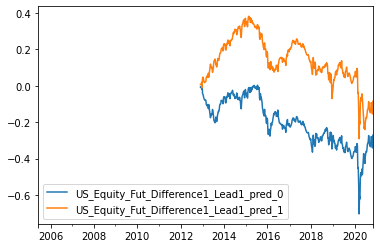

In [33]:
np.sign(signal.predictions).mask(signal.predictions.abs()<0, 0).multiply(target.diff(), axis=0).cumsum().plot()

In [30]:
signal.predictions

US_Equity_Fut_Difference1_Lead1_pred_0  \
2012-11-30                               -0.001648   
2012-12-07                               -0.001657   
2012-12-14                               -0.001648   
2012-12-21                               -0.001637   
2012-12-28                               -0.001577   
...                                            ...   
2020-10-09                                0.001490   
2020-10-16                                0.001449   
2020-10-23                                0.001070   
2020-10-30                                0.000845   
2020-11-06                                0.000786   

            US_Equity_Fut_Difference1_Lead1_pred_1  
2012-11-30                                0.001193  
2012-12-07                                0.000215  
2012-12-14                                0.000544  
2012-12-21                                0.001807  
2012-12-28                                0.000758  
...                                            ...  
2020-10-09                                0.000263  
2020-10-16                                0.000327  
2020-10-23                                0.000305  
2020-10-30                                0.000273  
2020-11-06                                0.000161  

[415 rows x 2 columns]

In [ ]:
wf.target_lead

In [ ]:
sig = tradeSignal.signals

In [ ]:
np.sign(tradeSignal.predictions).multiply(target.diff(), axis=0).dropna().cumsum().plot()

In [23]:
data = runner.get_data()
target = data[spec.target.name]

In [ ]:
target.plot()

In [ ]:
tradeSignal.signals.multiply(target, axis=0).dropna().cumsum().plot()

In [ ]:
t2.signals.multiply(target, axis=0).dropna().cumsum().plot()

In [ ]:
test = t2.wf[-1].model.base_estimator_

In [ ]:
t2.wf.fitted

In [ ]:
t2 = ThresholdSingSignal(tradeSignal.wf, threshold=0.00001)

In [ ]:
t2.signals

In [ ]:
signal = ThresholdSingSignal(wf, threshold=0.001, expanding=spec.data_splitter.expanding, )

In [ ]:
signal.signal

In [ ]:
signal.signal.multiply(target, axis=0).cumsum().dropna().plot()

In [ ]:
average_forecast = signal.predictions

In [ ]:
wf[0].model

## and can change the model generation scripts

In [ ]:
import itertools
def test(x, y):
    print(' we had overwritten the model generation method')
    return 1

runner.overwrite({
    'make_model': make_model
#     'custom_loss': custom_loss,
#     'custom_loss2': custom_loss2
})